In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.fem_utils import WaveguideTemplate

import gdsfactory as gf

from utils.meep_utils.runner import MeepRunner
from utils.meep_utils.digital_twins.mmi import MMI1x2Twin
from utils.general_utils import interpolate_design_parameter, plot_spectra

#### Cross section definition (Femwell)

In [2]:
n_core=3.47        # Silicon
n_box=1.444        # Bottom Oxide
n_clad=1.444       # Top Oxide (Symmetric is standard for Couplers)
thickness=0.22     # 220 nm
slab_thickness=0.0 # Strip Waveguide
domain_width=6.0
resolution=0.03    # High resolution for accurate gap physics

target_wavelength = 1.55
widths = np.linspace(4, 7, 10)  # MMI widths from 4 to 7 microns

In [3]:
n_core = 3.47
n_box = 1.444
n_clad = 1.444
domain_width = 10.0
resolution = 0.05

target_width = 6.0
widths = np.linspace(4, 8, 10)  # MMI widths from 4 to 8 microns
wavelength = 1.55

process_pdk = WaveguideTemplate(
    n_core=n_core,       
    n_box=n_box,      
    n_clad=n_clad,      
    thickness=thickness,     
    slab_thickness=slab_thickness, 
    domain_width=domain_width,
    resolution=resolution  
)

In [4]:
l3db_list = []

print(f"Starting MMI Design Sweep...")

for width_mmi in widths:
    modes_neffs = []
    try:
        mmi_modes = process_pdk.solve_modes(width=width_mmi, wavelength=wavelength, num_modes=2)
        [modes_neffs.append(np.real(mode.n_eff)) for mode in mmi_modes]

        delta_n = modes_neffs[0] - modes_neffs[1]
        L_pi = wavelength / (2 * delta_n)

        l3db_list.append(3/8 * L_pi)

        print(f"Width={width_mmi:.2f}um | dn={delta_n:.4f} | L_3dB={3/8 * L_pi:.2f} um")

    except ValueError as e:
        print(f"Width={width_mmi:.2f}um: {e}")
        l3db_list.append(np.nan)

Starting MMI Design Sweep...
Width=4.00um | dn=0.0201 | L_3dB=14.44 um
Width=4.44um | dn=0.0161 | L_3dB=18.00 um
Width=4.89um | dn=0.0135 | L_3dB=21.51 um
Width=5.33um | dn=0.0111 | L_3dB=26.19 um
Width=5.78um | dn=0.0097 | L_3dB=29.99 um
Width=6.22um | dn=0.0084 | L_3dB=34.58 um
Width=6.67um | dn=0.0072 | L_3dB=40.41 um
Width=7.11um | dn=0.0063 | L_3dB=46.37 um
Width=7.56um | dn=0.0057 | L_3dB=51.13 um
Width=8.00um | dn=0.0052 | L_3dB=56.22 um


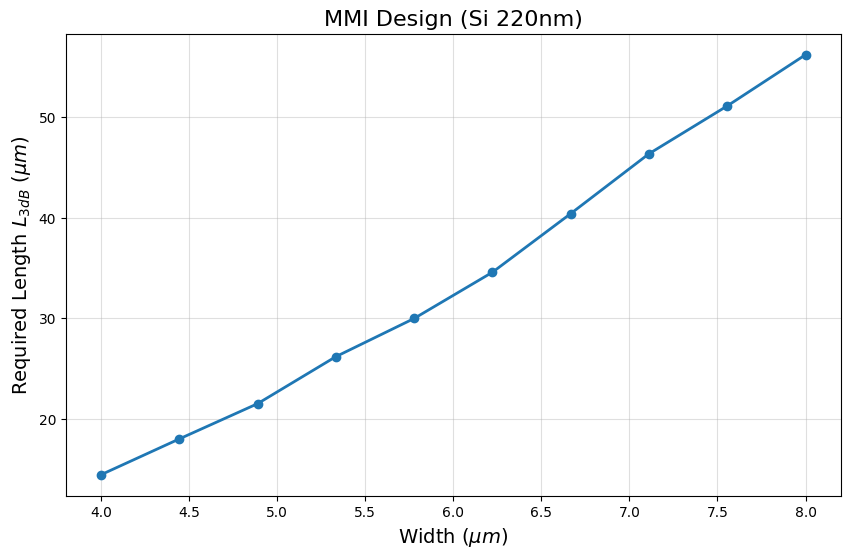

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(widths, l3db_list, 'o-', linewidth=2)
ax.set_xlabel(r'Width ($\mu m$)', fontsize=14)
ax.set_ylabel(r'Required Length $L_{3dB}$ ($\mu m$)', fontsize=14)
ax.set_title(f"MMI Design (Si 220nm)", fontsize=16)
ax.grid(True, alpha=0.4)
plt.show()

In [6]:
designed_length = interpolate_design_parameter(
    x_sweep=widths, 
    y_sweep=l3db_list, 
    target_x=target_width,
    interpolation_type='linear'
)

print(f"Interpolated Length for Width = {target_width} um is {designed_length:.3f} um")

Interpolated Length for Width = 6.0 um is 32.283 um


#### Verification (Meep FDTD)

In [7]:
engine = MeepRunner(n_core=n_core, n_clad=n_clad, resolution=50)

Checking geometry...
     prism, center = (21.4269,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 16 vertices:
          (0,-4,0)
          (0,-0.75,0)
          (-10,-0.25,0)
          (-10,0.25,0)
          (0,0.75,0)
          (0,4,0)
          (32.283,4,0)
          (32.283,3.5,0)
          (42.283,3,0)
          (42.283,2.5,0)
          (32.283,2,0)
          (32.283,-2,0)
          (42.283,-2.5,0)
          (42.283,-3,0)
          (32.283,-3.5,0)
          (32.283,-4,0)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)


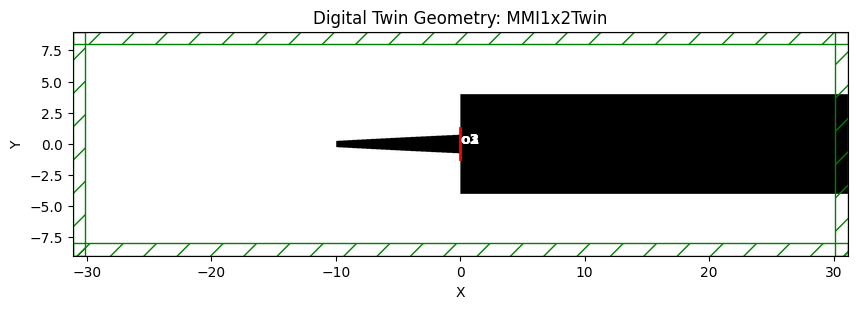

In [8]:
print("Checking geometry...")
mmi_1x2 = MMI1x2Twin(width_mmi=width_mmi, length_mmi=designed_length)
engine.plot_structure(mmi_1x2)

In [9]:
wvl, transmission = engine.simulate_component(mmi_1x2)

Running FDTD for MMI1x2Twin...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00115585 s
Working in 2D dimensions.
Computational cell is 62.28 x 18 x 0 with resolution 50
     prism, center = (21.4269,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 16 vertices:
          (0,-4,0)
          (0,-0.75,0)
          (-10,-0.25,0)
          (-10,0.25,0)
          (0,0.75,0)
          (0,4,0)
          (32.283,4,0)
          (32.283,3.5,0)
          (42.283,3,0)
          (42.283,2.5,0)
          (32.283,2,0)
          (32.283,-2,0)
          (42.283,-2.5,0)
          (42.283,-3,0)
          (32.283,-3.5,0)
          (32.283,-4,0)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
subpixel-averaging is 52.2973% done, 3.65326 s remaining
subpixel-averaging is 73.6898% done, 1.42831 s remaining
subpixel-averaging is 94.8331% done, 0.218156 s remaining
subpixel-averaging is 51.5912% done, 3.75737 s remaining
subpixel-aver

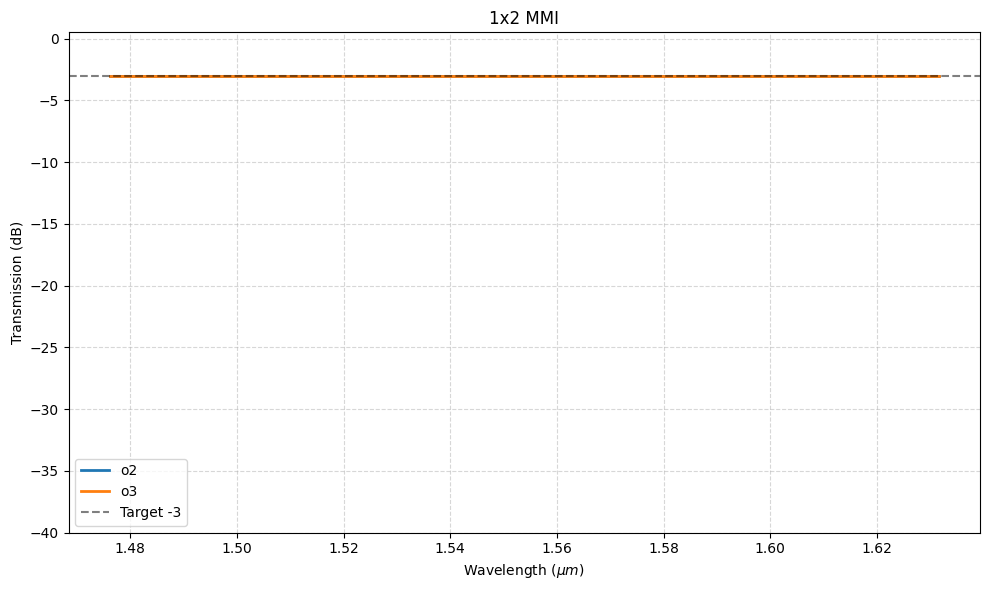

In [10]:
plot_spectra(wvl=wvl, transmissions=transmission, title="1x2 MMI", db_unit=True, target_level=-3)

#### Layout (GDSFactory)

In [12]:
width_taper = 1.5 # Standard width for the taper 'mouth'
length_taper = 10.0 # Standard adiabatic taper length
gap_mmi = 2.0 # Separation between input ports

mmi = gf.components.mmi1x2(
    width_mmi = width_mmi,
    length_mmi = designed_length,
    width_taper = width_taper,
    gap_mmi = gap_mmi,
    length_taper = length_taper
)

In [ ]:
mmi.plot()
mmi.write_gds("mmi_2x2.gds")
print(f"MMI Layout generated: L={designed_length} um")